In this notebook, we use the MICE method (https://www.statsmodels.org/devel/generated/statsmodels.imputation.mice.MICE.html) to impute missing data in the Enefit training set covering Sept 1, 2021 to May 31, 2023.

Citation:
Kristjan Eljand, Martin Laid, Jean-Baptiste Scellier, Sohier Dane, Maggie Demkin, Addison Howard. (2023). 
Enefit - Predict Energy Behavior of Prosumers. Kaggle. https://kaggle.com/competitions/predict-energy-behavior-of-prosumers

# 1. Missing data

First, we check how much of the data is missing. Below, we see that only the 'target' and '48h_shift' column have missing data.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

df = pd.read_csv('/kaggle/input/trainingdata/trainingData.csv') 
df['datetime'] = pd.to_datetime(df['datetime'])

# Data containes 7 columns; 'county', 'is_business', 'is_consumption', and 'product_type', which are categorical, and each determine a time series
# 'target' is the data we want to predict; '48h_shift' is the 48-hour lag. We have to predict 48 hours in advance
# 'datetime' is the date that we need the forecast for



There is missing data in the 'target' and '48h_shift columns, as seen below:

In [2]:
subframe_with_nan = df[df.isna().any(axis=1)]
subframe_with_nan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27744 entries, 1993440 to 2021183
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   county          27744 non-null  float64       
 1   is_business     27744 non-null  float64       
 2   is_consumption  27744 non-null  float64       
 3   product_type    27744 non-null  float64       
 4   target          0 non-null      float64       
 5   48h_shift       0 non-null      float64       
 6   datetime        27744 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(6)
memory usage: 1.7 MB


As seen in the EDA notebook EnefitEDA, the dataframe contains 132 separate timeseries, each of them described by a tuple ('county', 'is_business', 'is_consumption', 'product_type'). We call such a tuple (county_value, is_business_value, is_consumption_value, product_type) the **signature** of the time series.

Some of the time series have NaN target values, as we saw above. We will impute this missing data using the Multivariate Imputation by Chained Equations (MICE) method using the scikit-learn IterativeInputer: https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html 

In order to use MICE, we will choose some full series (with no missing data) which are highly correlated with the series whose data we try to inpute. Indeed, we can easily find such series, especially among those with similar signatures.

In the figure below, we see the correlation values between timeseries with signatures (c, 0, 0, 1) and (c, 0, 1, 1), where c ranges among county values. 
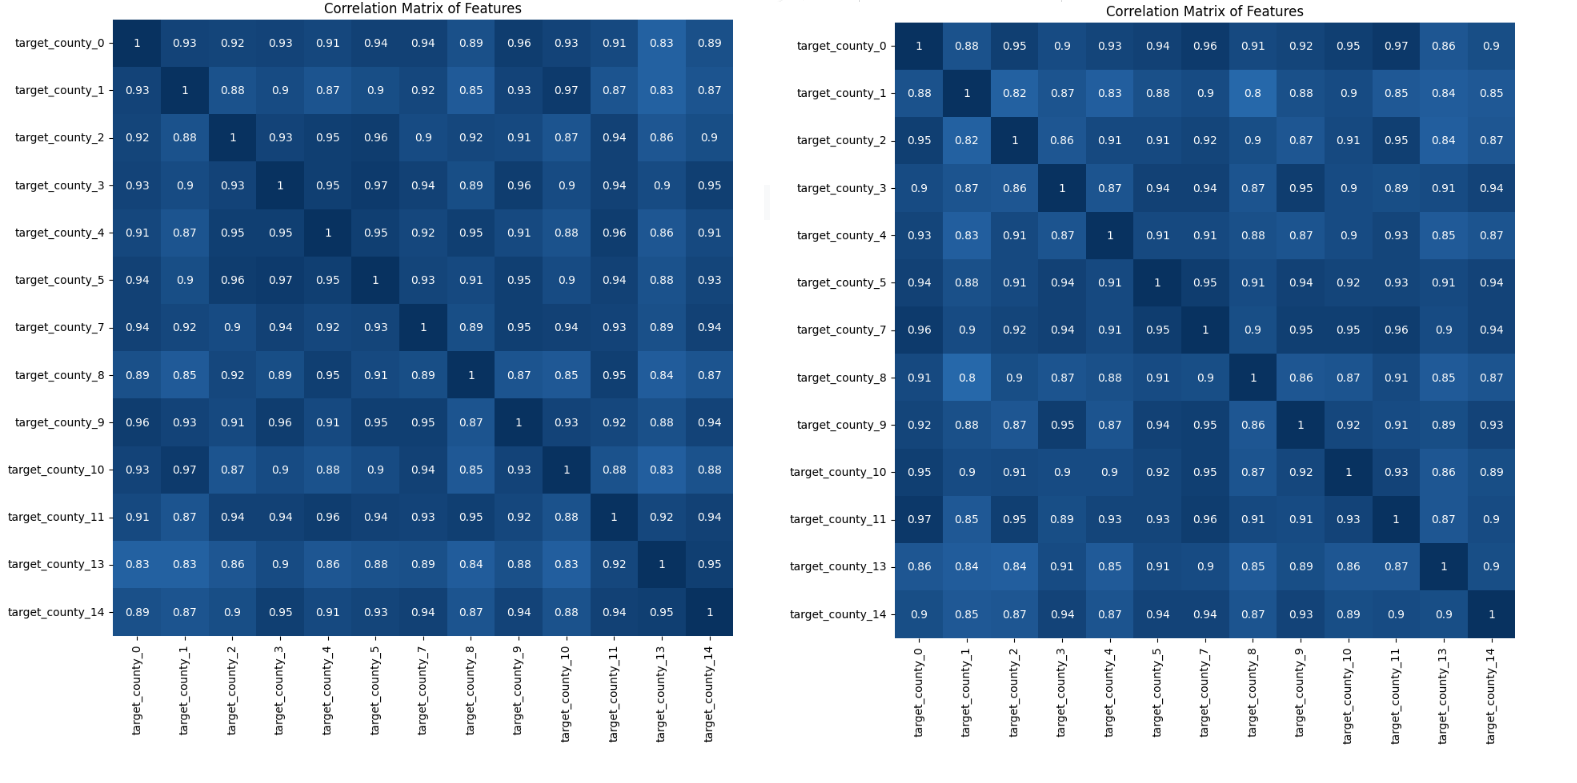


From the series whose correlations are computed above, two are missing data, with signature (2, 0, 0, 1) and (2, 0, 1, 1). We illustrate our method with the series with signature (2, 0, 0, 1)

In [3]:
subframe_2001 = df[(df['county']==2) & (df['is_business']==0) & (df['is_consumption'] == 0) & (df['product_type']==1)]
print(" Signature (2, 0, 0, 1) description is ", subframe_2001.info())

<class 'pandas.core.frame.DataFrame'>
Index: 15312 entries, 84980 to 1995599
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   county          15312 non-null  float64       
 1   is_business     15312 non-null  float64       
 2   is_consumption  15312 non-null  float64       
 3   product_type    15312 non-null  float64       
 4   target          14592 non-null  float64       
 5   48h_shift       14592 non-null  float64       
 6   datetime        15312 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(6)
memory usage: 957.0 KB
 Signature (2, 0, 0, 1) description is  None


# 2. Imputing data

We initiate 

In [4]:
from enefitutilsimputation import *

series =  SignedTimeSeries(df)
imputed_series = ImputedTimeSeries(series)

imputed_series.data.head()

IndentationError: expected an indented block after 'else' statement on line 98 (enefitutilsimputation.py, line 100)

In [ ]:
errors1 = []
for i in range(100):
    errors1.append(sts1.calculate_error(column_name, all_corr = True ))
    
column_name = 'target_2_0_0_1'
plt.hist(errors1, bins=20, color='skyblue', edgecolor='black')
plt.title(f'Histogram of 100 random county-ranged imputations of {column_name}')
plt.xlabel(column_name)
plt.ylabel('Frequency')
plt.show()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1465 entries, 2021-09-01 00:00:00 to 2021-11-01 00:00:00
Freq: h
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   target_county_0   1465 non-null   float64
 1   target_county_1   1465 non-null   float64
 2   target_county_2   0 non-null      float64
 3   target_county_3   1465 non-null   float64
 4   target_county_4   1465 non-null   float64
 5   target_county_5   1465 non-null   float64
 6   target_county_7   1465 non-null   float64
 7   target_county_8   1465 non-null   float64
 8   target_county_9   1465 non-null   float64
 9   target_county_10  1465 non-null   float64
 10  target_county_11  1465 non-null   float64
 11  target_county_13  1465 non-null   float64
 12  target_county_14  1465 non-null   float64
 13  target_county_15  1465 non-null   float64
dtypes: float64(14)
memory usage: 171.7 KB
None


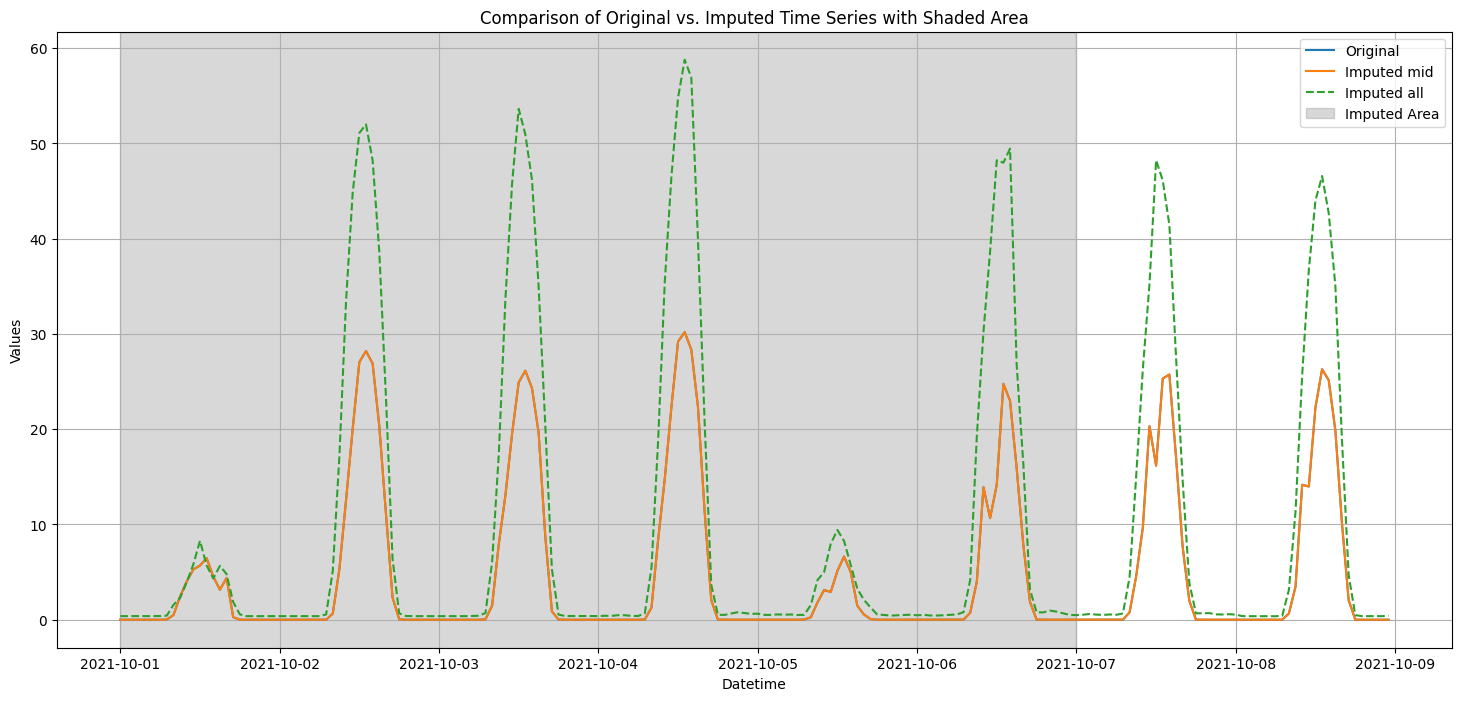

In [9]:

bool_mapping = {0: False, 1: True}

def plot_target(county_value, is_business_value, is_consumption_value, product_type_value, df):
    # Map "is_business' and 'is_consumption' values to True/False
    is_business_value = bool_mapping[is_business_value]
    is_consumption_value = bool_mapping[is_consumption_value]
    
    
    filtered_df = df[(df['county'] == county_value) & (df['is_business'] == is_business_value) & \
                     (df['is_consumption'] == is_consumption_value) & (df['product_type'] == product_type_value)].copy()
    
    filtered_df.set_index('datetime', inplace=True)
    
    if not filtered_df.empty:
        plt.figure(figsize=(10, 6))
        plt.plot(filtered_df.index.to_list(), filtered_df['target'].to_list())
        plt.title(f'Target Time Series for county={county_value}, business={is_business_value},  consumption={is_consumption_value}, product type={product_type_value}')
        plt.xlabel('Time')
        plt.ylabel('Target Value')
        plt.show()
    else:
        print(f"No matching data for county={county_value}, is_business={is_business_value},  is_consumption={ is_consumption_value}, product_type={product_type_value}")

        
test_data=data.copy()
test_data.loc['2021-09-01 00:00:00':'2021-11-01 00:00:00', 'target_county_2'] = np.nan

subframe_with_nan = test_data[test_data.isna().any(axis=1)]
print(subframe_with_nan.info())

imputer = IterativeImputer()
# Fit and transform the DataFrame to impute missing values
imputed_data1 = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
imputed_data2 = pd.DataFrame(imputer.fit_transform(test_data), columns=test_data.columns)


# Plotting
plt.figure(figsize=(18, 8))

# Plot the original time series
plt.plot(data.index.to_list()[24*30:24*38], data['target_county_2'].to_list()[24*30:24*38], label='Original')

plt.plot(data.index.to_list()[24*30:24*38], imputed_data1['target_county_2'].to_list()[24*30:24*38], label='Imputed mid')

# Plot the imputed time series
plt.plot(data.index.to_list()[24*30:24*38], imputed_data2['target_county_2'].to_list()[24*30:24*38], label='Imputed all', linestyle='--')

plt.axvspan('2021-10-01 00:00:00', '2021-10-07 00:00:00', alpha=0.3, color='gray', label='Imputed Area')



plt.title('Comparison of Original vs. Imputed Time Series with Shaded Area')
plt.xlabel('Datetime')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
n_samples = 100

# List to store imputed DataFrames
imputed_dfs = []

# Perform MICE imputation multiple times
for _ in range(n_samples):
    imputer = IterativeImputer()
    imputed_df = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
    imputed_dfs.append(imputed_df)

# Calculate confidence intervals for each column
confidence_intervals = {}
for col in data.columns:
    imputed_values = np.vstack([df[col].values.reshape(1, -1) for df in imputed_dfs])
    lower_bound = np.percentile(imputed_values, 2.5, axis=0)
    upper_bound = np.percentile(imputed_values, 97.5, axis=0)
    confidence_intervals[col] = {'lower_bound': lower_bound, 'upper_bound': upper_bound}

# Display confidence intervals
for col, intervals in confidence_intervals.items():
    print(f"{col}:")
    print(f"  Lower Bound: {intervals['lower_bound']}")
    print(f"  Upper Bound: {intervals['upper_bound']}")
    print()

target_county_0:
  Lower Bound: [ 0.713  1.132  0.49  ... 22.428  5.086  2.921]
  Upper Bound: [ 0.713  1.132  0.49  ... 22.428  5.086  2.921]

target_county_1:
  Lower Bound: [0.    0.    0.    ... 3.96  1.311 0.769]
  Upper Bound: [0.    0.    0.    ... 3.96  1.311 0.769]

target_county_2:
  Lower Bound: [0.29321609 0.29985349 0.28968353 ... 0.936      0.         0.        ]
  Upper Bound: [0.29321609 0.29985349 0.28968353 ... 0.936      0.         0.        ]

target_county_3:
  Lower Bound: [0.    0.    0.    ... 2.291 0.086 0.125]
  Upper Bound: [0.    0.    0.    ... 2.291 0.086 0.125]

target_county_4:
  Lower Bound: [0.    0.    0.    ... 0.923 0.082 0.002]
  Upper Bound: [0.    0.    0.    ... 0.923 0.082 0.002]

target_county_5:
  Lower Bound: [0.    0.    0.    ... 4.594 2.175 0.709]
  Upper Bound: [0.    0.    0.    ... 4.594 2.175 0.709]

target_county_7:
  Lower Bound: [0.    0.    0.    ... 4.001 1.034 1.114]
  Upper Bound: [0.    0.    0.    ... 4.001 1.034 1.114]

targ

In [64]:
def mae_error(range_start, range_end, column_name, data, scale = True): #chacks error in a given range by doing MICE imputation in a given column
    start_date = data.index[range_start]; end_date = data.index[range_end]; 
    print(start_date, end_date)
    # replace some values by NaN
    test_data=data.copy()
    test_data.loc[start_date : end_date, column_name] = np.nan
    #scaling
    if scale == True:
        ranges={column: data[column].nlargest(10).tolist()[0] for column in data.columns}
        print(ranges)
        for column in data.columns:
            test_data[column] = np.where(test_data[column] > ranges[column], ranges[column], test_data[column])
        test_data=test_data.div(ranges, axis=1)
    # impute data
    imputer = IterativeImputer()
    imputed_data = pd.DataFrame(imputer.fit_transform(test_data), columns=test_data.columns)
    print(imputed_data.head())
    # rescale if necessary
    if scale ==  True:
        imputed_data= imputed_data.multiply(ranges, axis=1)
        print(imputed_data.head())
    # plot range
    plt.figure(figsize=(18, 8))
    plt.plot(data.index.to_list()[range_start:range_end], data[column_name].to_list()[range_start:range_end], label='Original')
    plt.plot(data.index.to_list()[range_start:range_end], imputed_data[column_name].to_list()[range_start:range_end], label='Imputed data', linestyle='--')
    # calculate error
    return tf.keras.metrics.mean_absolute_error(data[column_name].to_list()[range_start:range_end], imputed_data[column_name].to_list()[range_start:range_end]).numpy()

In [68]:
data.columns

Index(['target_county_0', 'target_county_1', 'target_county_2',
       'target_county_3', 'target_county_4', 'target_county_5',
       'target_county_7', 'target_county_8', 'target_county_9',
       'target_county_10', 'target_county_11', 'target_county_13',
       'target_county_14', 'target_county_15'],
      dtype='object')

2021-10-01 00:00:00 2021-10-09 00:00:00
   target_county_1  target_county_2  target_county_3  target_county_4  \
0              0.0         0.234847              0.0              0.0   
1              0.0         0.234847              0.0              0.0   
2              0.0         0.234847              0.0              0.0   
3              0.0         0.234847              0.0              0.0   
4              0.0         0.382699              0.0              0.0   

   target_county_5  target_county_7  target_county_8  target_county_9  \
0            0.000              0.0              0.0              0.0   
1            0.000              0.0              0.0              0.0   
2            0.000              0.0              0.0              0.0   
3            0.000              0.0              0.0              0.0   
4            0.479              0.0              0.0              0.0   

   target_county_10  target_county_11  target_county_13  target_county_14  \
0    

4.9979987

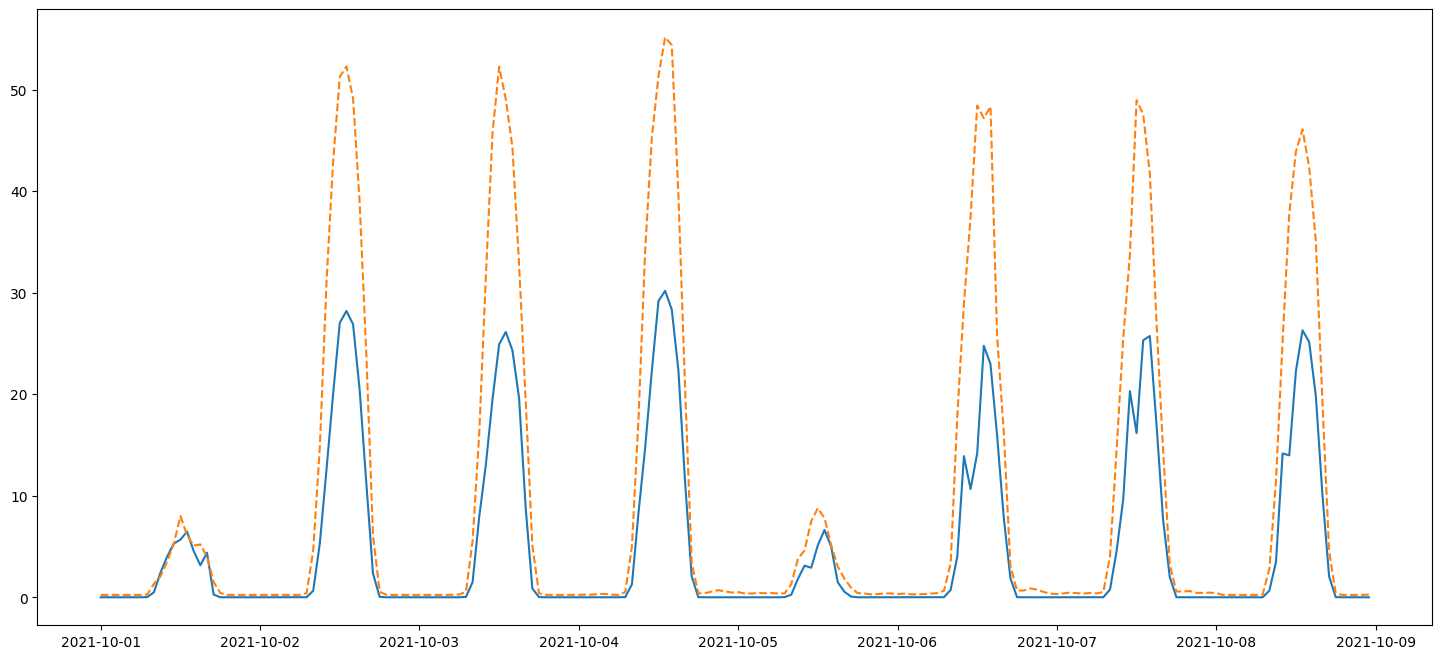

In [69]:
mae_error(24*30, 24*38, 'target_county_2', data[['target_county_1', 'target_county_2',
       'target_county_3', 'target_county_4', 'target_county_5',
       'target_county_7', 'target_county_8', 'target_county_9',
       'target_county_10', 'target_county_11', 'target_county_13',
       'target_county_14', 'target_county_15']], scale = False)

2021-10-01 00:00:00 2021-10-09 00:00:00
{'target_county_1': 121.146, 'target_county_2': 222.625, 'target_county_3': 327.491, 'target_county_4': 250.864, 'target_county_5': 451.432, 'target_county_7': 854.516, 'target_county_8': 375.187, 'target_county_9': 506.752, 'target_county_10': 569.614, 'target_county_11': 1234.168, 'target_county_13': 142.468, 'target_county_14': 353.558, 'target_county_15': 325.828}
   target_county_1  target_county_2  target_county_3  target_county_4  \
0              0.0         0.001053              0.0              0.0   
1              0.0         0.001053              0.0              0.0   
2              0.0         0.001053              0.0              0.0   
3              0.0         0.001053              0.0              0.0   
4              0.0         0.001717              0.0              0.0   

   target_county_5  target_county_7  target_county_8  target_county_9  \
0         0.000000              0.0              0.0              0.0   
1   

5.002099

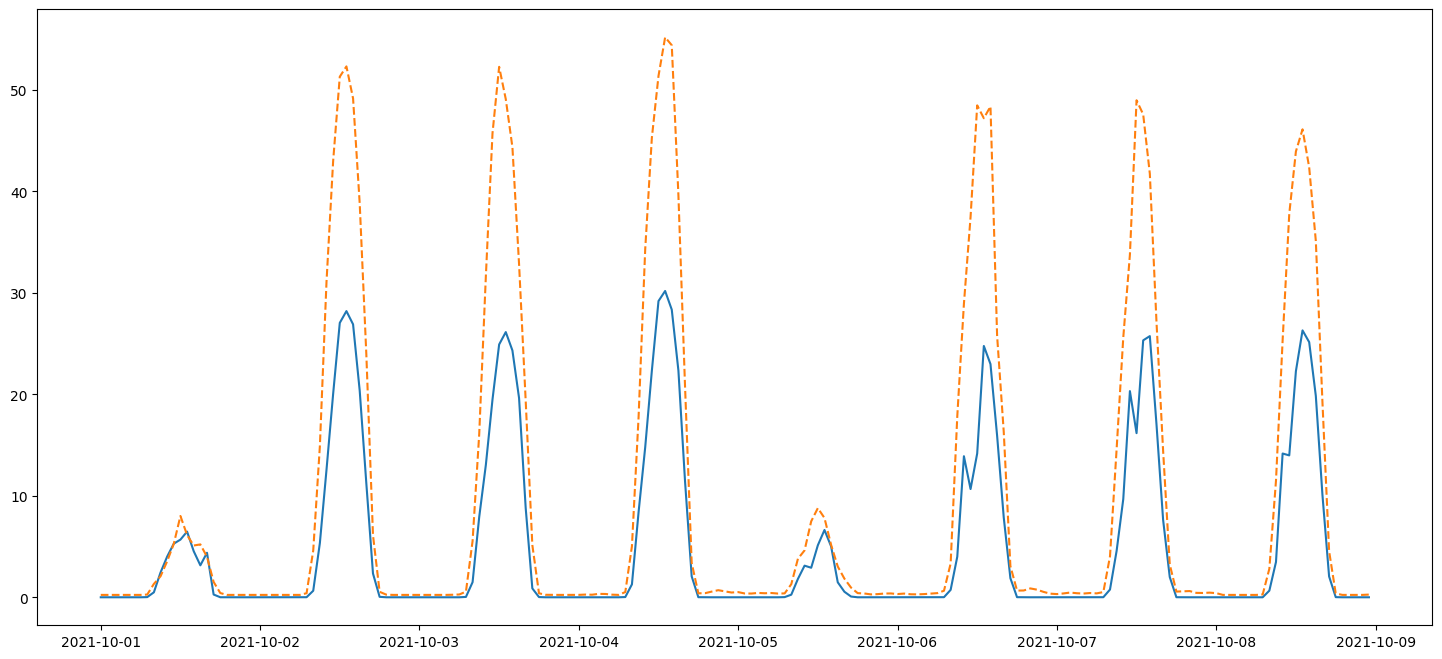

In [70]:
mae_error(24*30, 24*38, 'target_county_2', data[['target_county_1', 'target_county_2',
       'target_county_3', 'target_county_4', 'target_county_5',
       'target_county_7', 'target_county_8', 'target_county_9',
       'target_county_10', 'target_county_11', 'target_county_13',
       'target_county_14', 'target_county_15']], scale = True)

In [67]:
column_name=  'target_county_0'
top_200_values = data[column_name].nlargest(10).tolist()

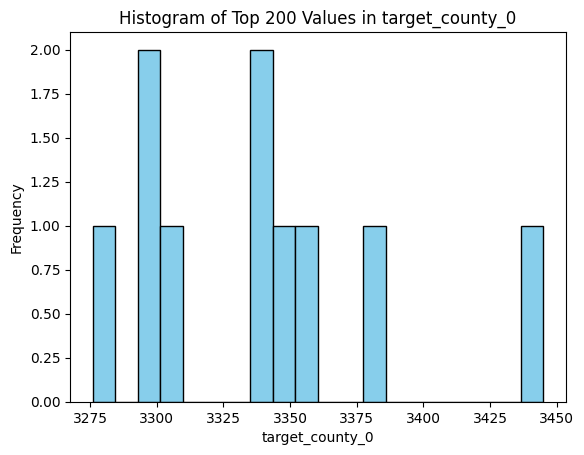

In [60]:
plt.hist(top_200_values, bins=20, color='skyblue', edgecolor='black')
plt.title(f'Histogram of Top 200 Values in {column_name}')
plt.xlabel(column_name)
plt.ylabel('Frequency')
plt.show()

In [49]:
np.array(top_200_values).mean()

2838.97236

In [50]:
np.array(top_200_values).std()

256.96032218348495